# Gaussian Naive Bayes 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data Load and Inspection

In [2]:
loan_df = pd.read_csv('loan_data.csv')
loan_df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
#Transform the purpose column.
loan_df = pd.get_dummies(loan_df, columns=['purpose'], drop_first=True)
loan_df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [4]:
unique_classes = loan_df['not.fully.paid'].unique()
unique_classes

array([0, 1])

/opt/homebrew/Caskroom/miniforge/base/envs/nasa/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


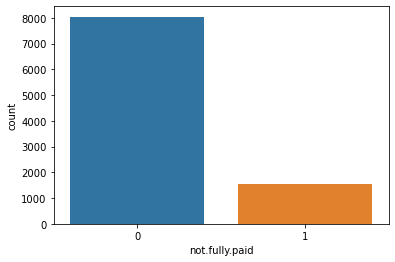

In [5]:
sns.countplot(loan_df['not.fully.paid'])
plt.show()

In [6]:
X = loan_df.drop('not.fully.paid', axis=1)
y = loan_df['not.fully.paid']
feature_columns = X.columns

In [7]:
#stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
print("Number of train and test data: ", len(X_train), len(X_test))

Number of train and test data:  7662 1916


/var/folders/lc/0svhcdcn6pd728qrzry78cj00000gn/T/ipykernel_1744/2120737112.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


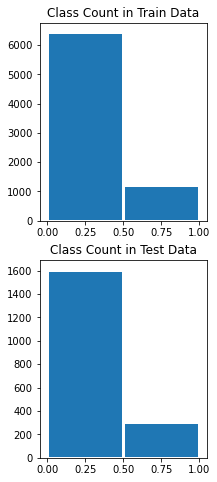

In [9]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(3,8))

ax1.hist(y_train, bins=2, linewidth=3, edgecolor="white")
ax1.set_title("Class Count in Train Data")
ax2.hist(y_test, bins=2, linewidth=3, edgecolor="white")
ax2.set_title("Class Count in Test Data")

fig.show()

The ratio of the classes in both the train and test set seems to be similar.

## Gaussian Naive Bayes

### Statistics of the training data

In [10]:
def calculate_mu_sigma(train_data, train_labels):
    '''Calculate the mean and the standard deviation for the training dataset for all classes.
    '''
    
    
    temp_train_data = train_data.copy()
    temp_train_data['class'] = train_labels
    
    
    mu = temp_train_data.groupby('class')[feature_columns].mean() #mean
    sigma = temp_train_data.groupby('class')[feature_columns].std() #standard deviation
    
    return mu.reset_index(), sigma.reset_index()

In [11]:
def calculate_class_prior(train_data, train_labels):
    '''Calculate the class probability.
    '''
    
    temp_train_data = train_data.copy()
    temp_train_data['class'] = train_labels
    
    class_prior_record = temp_train_data.groupby('class').size().div(len(temp_train_data))
    
    return class_prior_record.reset_index()

In [12]:
mu, sigma = calculate_mu_sigma(train_data=X_train, train_labels=y_train)

In [13]:
class_prior_record = calculate_class_prior(train_data=X_train, train_labels=y_train)

### Test data

In [14]:
def calc_gaussian_prob(row_data, mu, sigma):
    '''Calculate the gaussian probability density for a given row.
    '''
    
    a = 1/(sigma*np.sqrt(2*np.pi))
    b = np.exp((-1/2)*(np.square((row_data-mu)/sigma)))
    
  
    return np.log(a*b)

In [15]:
def likelihood_calculation(test_data, mu, sigma, unique_classes, feature_columns):
    '''Calculate the likelihood density probability of the test data.
    '''
    
    likelihood_record = {}
    
    for cls_idx, cls_name in enumerate(unique_classes):
        
        likelihood_record[cls_name] = test_data.copy()
        
        mu_class = np.asarray(mu.loc[mu['class'] == cls_name].drop('class', axis=1)).reshape(-1)
        sigma_class = np.asarray(sigma.loc[sigma['class'] == cls_name].drop('class', axis=1)).reshape(-1)

        likelihood_record[cls_name] = likelihood_record[cls_name].apply(lambda x: calc_gaussian_prob(x,
                                                                        mu_class, sigma_class), 
                                                                                         axis=1)
        
    return likelihood_record

In [16]:
def posterior_calculation(likelihood_records, unique_classes, class_prior_record):
    '''Calculates the posterior log probability
    '''
    
    probabilities = {}
    
    for cls_idx, cls_name in enumerate(unique_classes):
        class_prior = class_prior_record.loc[class_prior_record['class'] == 0].drop('class', 
                                                                                axis=1).values.reshape(-1)
 
        
        likelihood_class = np.sum(likelihood_records[cls_name], axis=1)
        posterior_probs = np.log(class_prior)+likelihood_class
        likelihood_records[cls_name]['posterior_log_prob'] = posterior_probs 

           
        probabilities[cls_name] = posterior_probs
    
    
    all_probabilities = pd.DataFrame(probabilities)
    log_sum_probs = np.sum(np.exp(all_probabilities), axis=1) #the denominator to normalize
    
    for cls_idx, cls_name in enumerate(unique_classes):
        
        #normalizing the result between 0 and 1 to represent probability.
        likelihood_records[cls_name]['posterior_prob'] = np.exp(likelihood_records[cls_name]['posterior_log_prob'])\
                                                                /log_sum_probs
    
    return likelihood_records

In [17]:
def get_max_class_prediction(test_records, unique_classes):
    '''Given the posterior probabilities of all classes, find the highest prob.
    '''
    predictions = {}
    
    for cls_idx, cls_name in enumerate(unique_classes):
        
        predictions[cls_name] = test_records[cls_name]['posterior_prob']
    
    predictions = pd.DataFrame.from_dict(predictions)
    max_preds = predictions.idxmax(axis=1)
    
    
    return max_preds
    

In [18]:
def check_accuracy(predictions, actual_labels):
    '''Compare the predictions with the test labels.
    '''
    
    comparison = predictions == actual_labels
    accuracy = comparison.sum()/len(actual_labels) * 100
    
    return accuracy

In [20]:
likelihood_records = likelihood_calculation(X_test, mu, sigma, unique_classes, feature_columns)

In [21]:
test_records = posterior_calculation(likelihood_records, unique_classes, class_prior_record)

In [22]:
test_records[0]

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,posterior_log_prob,posterior_prob
0,-2.425946,1.877183,-6.364678,-0.427006,-2.932214,-6.065299,-9.337013,-11.231197,-4.633551,-1.860830,-0.328378,0.395279,0.068443,-0.920269,0.755227,0.464039,0.58414,0.515002,-42.041432,0.238705
1,-0.033090,1.528347,-7.028538,-0.435161,-3.301068,-4.682500,-8.755289,-11.293726,-4.285968,-1.860830,-0.328378,0.395279,0.068443,-0.920269,0.755227,0.464039,0.58414,0.515002,-38.788705,0.941587
2,-0.033090,2.502648,-7.854834,-1.527183,-3.152715,-4.563182,-8.773126,-11.258838,-4.539058,-1.860830,-0.328378,0.395279,0.068443,-0.562775,0.755227,0.464039,0.58414,0.515002,-39.343595,0.751688
3,-0.033090,2.668454,-6.992060,-2.821442,-2.888000,-4.606141,-9.155909,-11.354455,-5.346669,-1.623392,-0.328378,0.395279,0.068443,-0.562775,0.755227,0.464039,0.58414,0.515002,-40.436092,0.774437
4,-0.033090,1.792607,-6.249231,-0.415100,-3.098121,-4.897300,-8.989919,-11.334692,-4.367766,-1.642054,-0.328378,0.395279,0.068443,-0.562775,0.755227,-6.966665,0.58414,0.515002,-44.948759,0.473319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,-0.033090,2.593534,-6.241246,-0.485413,-4.078717,-4.798855,-8.843985,-11.313835,-4.431227,-1.623392,-0.328378,0.395279,0.068443,-0.562775,0.755227,0.464039,0.58414,0.515002,-37.539614,0.799063
1912,-2.425946,2.051433,-6.458863,-0.558159,-5.835573,-4.567356,-8.877000,-12.358872,-5.005233,-1.916818,-0.328378,0.395279,0.068443,-0.920269,0.755227,0.464039,0.58414,0.515002,-44.593270,0.091979
1913,-0.033090,2.708149,-6.923292,-0.420059,-4.487997,-4.682500,-8.998758,-11.234528,-4.293133,-1.860830,-0.328378,0.395279,0.068443,-0.920269,0.755227,0.464039,0.58414,0.515002,-38.866920,0.870705
1914,-0.033090,2.707908,-6.402450,-0.416245,-2.977178,-4.576110,-8.791510,-11.224134,-4.414027,-1.623392,-0.328378,0.395279,-2.995969,-0.562775,0.755227,0.464039,0.58414,0.515002,-39.098027,0.956566


In [23]:
test_records[1]

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,posterior_log_prob,posterior_prob
0,-1.144458,2.356677,-6.372497,-0.534059,-2.915850,-5.596139,-9.292472,-11.767725,-4.472691,-2.288460,-0.312442,0.261658,0.261479,-0.969455,0.660329,0.402098,0.858536,0.158194,-40.881642,0.761295
1,-0.428275,0.630450,-7.151705,-0.518903,-3.210034,-4.939481,-8.734210,-11.754799,-4.319355,-2.288460,-0.312442,0.261658,0.261479,-0.969455,0.660329,0.402098,0.858536,0.158194,-41.568741,0.058413
2,-0.428275,2.728197,-7.486489,-1.521642,-3.250701,-4.516740,-8.759063,-11.784765,-4.729345,-2.288460,-0.312442,0.261658,0.261479,-0.529431,0.660329,0.402098,0.858536,0.158194,-40.451228,0.248312
3,-0.428275,2.738074,-7.117091,-2.360558,-2.948361,-4.438581,-9.110405,-11.832419,-5.695375,-2.062692,-0.312442,0.261658,0.261479,-0.529431,0.660329,0.402098,0.858536,0.158194,-41.669627,0.225563
4,-0.428275,2.295215,-6.315027,-0.515712,-3.191280,-4.548685,-8.945477,-11.823152,-4.490720,-1.962397,-0.312442,0.261658,0.261479,-0.529431,0.660329,-6.100379,0.858536,0.158194,-44.841932,0.526681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,-0.428275,2.749886,-6.314947,-0.549552,-4.211597,-4.487856,-8.804114,-11.813140,-4.583834,-2.062692,-0.312442,0.261658,0.261479,-0.529431,0.660329,0.402098,0.858536,0.158194,-38.920065,0.200937
1912,-1.144458,2.477968,-6.433481,-0.665345,-5.460468,-4.589123,-8.835525,-12.054760,-4.756833,-1.987573,-0.312442,0.261658,0.261479,-0.969455,0.660329,0.402098,0.858536,0.158194,-42.303567,0.908021
1913,-0.428275,2.625191,-7.051598,-0.525008,-4.247304,-4.939481,-9.019999,-11.746918,-4.298308,-2.288460,-0.312442,0.261658,0.261479,-0.969455,0.660329,0.402098,0.858536,0.158194,-40.774129,0.129295
1914,-0.428275,2.667974,-6.396314,-0.518772,-2.948499,-4.466559,-8.755841,-11.762245,-4.330175,-2.062692,-0.312442,0.261658,-4.513303,-0.529431,0.660329,0.402098,0.858536,0.158194,-42.190124,0.043434


In [27]:
predictions = get_max_class_prediction(test_records, unique_classes)

In [28]:
accuracy = check_accuracy(predictions, y_test)

In [29]:
accuracy

71.08559498956159

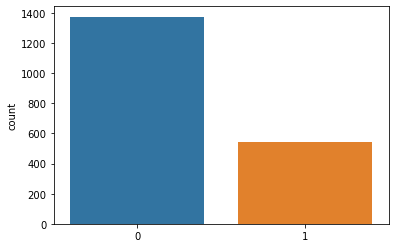

In [31]:
sns.countplot(predictions)
plt.show()